### Project 5: Re-visiting the Jester dataset in PySpark

#### Parameter comparisons:
**Project 2 parameters (Surprise Library)**
1) Data size = 100 randomly sampled users for 100 jokes
2) model = KNN with cosine similarity using the surprise library
3) RMSE = 4.818 after normalizing user ratings
4) Elapsed time: 1.0382 seconds

**New Implementations using PySpark**
1) Data size = 73,421 user x 100 jokes (original jester dataset size). That is about 734 times more data points than the surprise library set.
2) model = ALS in PySpark
3) 2 x 2 hyperparamter tuning (total 4 models)
4) 3-fold cross-validation

We will be comparsion the prediction differences, RMSE, and the time elapsed for running the PySpark code


In [28]:
from pyspark.sql.functions import col
from pyspark.sql.functions import explode
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import desc
from pyspark.sql import functions as F
import urllib.request
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, monotonically_increasing_id
import time
import numpy as np
from functools import reduce
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
#Set timer:
start = time.time()

Step 1: Download the three jester files and combine them:

In [16]:
url1 = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/jester-data-1.csv'
url2 = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/jester-data-2.csv'
url3 = 'https://raw.githubusercontent.com/stormwhale/data-mines/refs/heads/main/jester-data-3.csv'

urllib.request.urlretrieve(url1, 'jester-data-1.csv')
urllib.request.urlretrieve(url2, 'jester-data-2.csv')
urllib.request.urlretrieve(url3, 'jester-data-3.csv')

('jester-data-3.csv', <http.client.HTTPMessage at 0x2c3257b9dd0>)

In [17]:
#Set timer:
start = time.time()

#Build Spark session custom to my local computer setup:
spark = SparkSession.builder \
    .appName("OptimizedLocalSpark") \
    .master("local[16]") \
    .config("spark.driver.memory", "24g") \
    .config("spark.executor.memory", "24g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "64") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()
    
#Read the three files:
df1 = spark.read.csv('jester-data-1.csv', header=False, inferSchema=True)
df2 = spark.read.csv('jester-data-2.csv', header=False, inferSchema=True)
df3 = spark.read.csv('jester-data-3.csv', header=False, inferSchema=True)

#Combine the three dataframes by row:
df = df1.union(df2).union(df3)

#To chekc the size and shape of the dataframe:
print(f'Num of rows: {df.count()}\nNum of columns: {len(df.columns)}')

Num of rows: 73421
Num of columns: 101


Step 2: Data cleaning

In [18]:
# Remove the first column as it is a count for number of jokes rated by the user:
df = df.drop(df.columns[0])

#Replace all 99.0 values to Null
df = df.replace(99.0, None)

#All a user_id column:
df = df.withColumn(
    'user_id', 
    row_number().over(Window.orderBy(monotonically_increasing_id())))

#Rename the columns from 1 to 100 for the jokes:
jokes_col = [f'joke_{i+1}' for i in range(df.columns.__len__()-1)]
df = df.toDF(*(jokes_col + ['user_id']))
df = df.select(['user_id'] + jokes_col)


#Covert the df to long format:
n = len(df.columns) - 1 #Disregard the user_id column
joke_col = [c for c in df.columns if c != 'user_id'] #Select only the jokes column
stack_expr = ", ".join(f'"{i+1}", {c}' for i, c in enumerate(joke_col)) #Create a pair for the columns to stack

df_long = df.selectExpr('user_id', f"stack({n}, {stack_expr}) as (joke_id, rating)")

#Convert the column types into numeric values:
df_long = df_long.withColumn('joke_id', col('joke_id').cast('int'))

Step 3: train-test-split the dataset:

In [19]:
df_long_no_null = df_long.filter(col('rating').isNotNull())
train, test = df_long_no_null.randomSplit([0.8, 0.2], seed = 42)
print(f'Num of rows in train: {train.count()}')
print(f'Num of rows in test: {test.count()}')

Num of rows in train: 3309467
Num of rows in test: 826893


Step 4: Build and tune an ALS model:

In [ ]:
#Setting up ALS model:
als = ALS(
    userCol='user_id',
    itemCol='joke_id',
    ratingCol='rating',
    nonnegative=False,
    coldStartStrategy='drop',
    implicitPrefs=False,
    seed = 42
    )

#Setting tuning parameters:
param_grid = ParamGridBuilder()\
    .addGrid(als.rank, [10, 20])\
    .addGrid(als.regParam, [0.1, 0.5])\
    .build()
    
#Define evaluators:
rmse_eva = RegressionEvaluator(
    metricName='rmse',
    labelCol='rating',
    predictionCol='prediction'
)

#Set up cross-validation:
cv = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=rmse_eva,
    numFolds=3
)

#Fitting model:
cv_model = cv.fit(train)
best_model = cv_model.bestModel

#Generating predictions:
predictions = best_model.transform(test)

print('Best ALS model parameters:')
print('-'*80)
print(f'rank: {best_model.rank}')
print(f'regParm: {best_model._java_obj.parent().getRegParam()}')
print(f'Maxiter: {best_model._java_obj.parent().getMaxIter()}')
print('-'*80)
print(f'RMSE = {rmse_eva.evaluate(best_model.transform(test)):.3f}')

Best ALS model parameters:
--------------------------------------------------------------------------------
rank: 20
regParm: 0.5
Maxiter: 10
--------------------------------------------------------------------------------
RMSE = 4.15427216539553


Step 5: To generate user specific recommendations

In [21]:
rec_list = best_model.recommendForAllUsers(100)
#Put recommendation in dataframe:
rec_list = rec_list.select('user_id', explode('recommendations').alias('rec'))\
    .select('user_id', col('rec.joke_id').alias('joke_id'), col('rec.rating').alias('rating'))

#remove items that users have already rated in both train and test set:
user_seen = train.select(['user_id', 'joke_id']).union(test.select(['user_id', 'joke_id']))

#Exclude the seen jokes:
rec_unrated = rec_list.join(user_seen, on=['user_id','joke_id'], how='left_anti')

To get Top-N joke recommendations:

In [22]:
topN = 5
win_spec = Window.partitionBy('user_id').orderBy(desc('rating'))
final_rec = rec_unrated.withColumn('rank', F.rank().over(win_spec)).filter(F.col('rank') <= topN)
final_rec.show()

+-------+-------+------------+----+
|user_id|joke_id|      rating|rank|
+-------+-------+------------+----+
|     38|     72|   2.6869557|   1|
|     38|     89|   2.6127899|   2|
|     38|     65|   2.4433026|   3|
|     38|     76|    2.335305|   4|
|     38|     26|   2.1929462|   5|
|     94|     80|   3.6306744|   1|
|     94|     72|   3.3314579|   2|
|     94|     73|   3.2282088|   3|
|     94|    100|   3.1725347|   4|
|     94|     76|   3.0841897|   5|
|    104|     98|   -0.864941|   1|
|    104|    100|  -1.2248641|   2|
|    104|     83|  -1.2716812|   3|
|    104|     75|  -1.4375545|   4|
|    104|     81|  -1.4602803|   5|
|    111|     89|   0.7639573|   1|
|    111|     72|-0.009106692|   2|
|    111|     88| -0.18593886|   3|
|    111|     97| -0.25139844|   4|
|    111|     87| -0.32933736|   5|
+-------+-------+------------+----+
only showing top 20 rows


To get Top-N jokes for specific user:

In [25]:
#Define user_id:
user_id = 1

final_rec.filter(col('user_id')==user_id).show()

+-------+-------+-----------+----+
|user_id|joke_id|     rating|rank|
+-------+-------+-----------+----+
|      1|     89|  1.6574516|   1|
|      1|     72|-0.12083605|   2|
|      1|     93|-0.56045926|   3|
|      1|     76|-0.63118654|   4|
|      1|     83| -1.3879728|   5|
+-------+-------+-----------+----+



In [24]:
#End timer:
end = time.time()

minutes_remainer = int((end - start)//60)
seconds_remainer = int((end - start) % 60)

print(f'That is {minutes_remainer:.2f} minutes and {seconds_remainer:.2f} seconds elapsed')

That is 1.00 minutes and 26.00 seconds elapsed


C:\Users\godly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\pandas\conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Text(0, 0.5, 'counts')

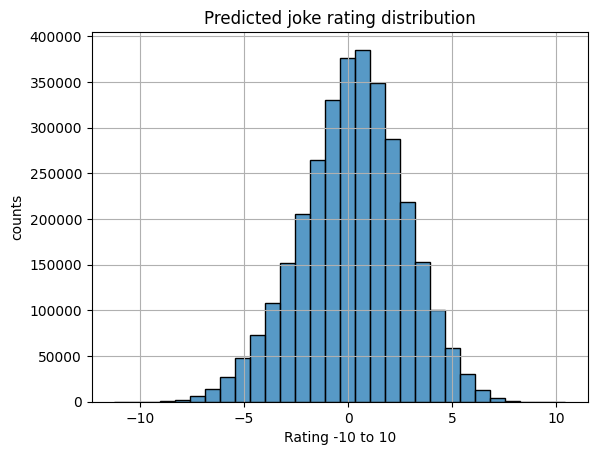

In [ ]:
   
#To visualize the predicted rating distributions:
rec_unrated_pd = rec_unrated.toPandas()
sns.histplot(x=rec_unrated_pd['rating'], bins=30)
plt.title('Predicted joke rating distribution')
plt.xlabel('Rating -10 to 10')
plt.grid(True)
plt.ylabel('counts')

### Summary:
In comparison to the error metrics (RMSE), the ALS model in PySpark performs better than the KNN model from the surprise library. The former achieves an RMSE of approximately 4.15, while the latter results in 4.818.

In terms of processing time, the surprise library took just over 1 second to run the script and generate predictions. In contrast, the ALS model in PySpark required about 1 minute and 26 seconds to tune hyperparameters across 4 different models, each evaluated using 3-fold cross-validation. It's important to note that predicted ratings from the ALS model are automatically normalized as part of its algorithm, which introduces a difference in output compared to the surprise library, which does not normalize ratings by default.

On the surface, PySpark's processing time may not seem as fast as loading a local Python library such as surprise for generating recommendations. However, when considering that the dataset used in this case is roughly 734 times larger than the one in Project 2, PySpark’s performance is relatively efficient. Additionally, since 4 ALS models were tuned using 3-fold cross-validation, if we divide the total time (86 seconds) by the number of models trained, PySpark used only about 21.5 seconds per model to process a dataset more than 700 times larger. This highlights the efficiency of Spark's parallel processing capabilities.

By design, Spark distributes workloads across multiple cores or machines, allowing for parallel execution and significantly faster processing compared to serial computation, where tasks are performed one at a time. Furthermore, Spark uses in-memory computation, which avoids the repeated disk read/write cycles seen in systems like Hadoop, thereby reducing latency. Even when used in a local environment — such as a personal computer equipped with a multi-core CPU and 16–32 GB of RAM — PySpark can make a significant difference in handling large volumes of data.

When deciding whether to use Spark, the key considerations typically include data size, computational complexity, and RAM limitations. Among these, data size is often the most important factor. Larger datasets demand more complex calculations and higher memory requirements, both of which Spark handles well. For example, while pandas or NumPy may crash or become inefficient when handling datasets around 50 GB, Spark's distributed architecture makes it a practical and scalable solution.

However, for smaller datasets, using Spark can be counterintuitive. In such cases, libraries like pandas or NumPy are often faster and easier to implement, due to their lower overhead and simplicity.


